<span style="text-align: center">
<h1>Anomalies detection: Intrafield & Interfield</h2>
<h2>(parcels analysis based on Sentinel-2 COG)</h2>
</span>

In the following notebook, we introduce a more advanced analysis to detect anomalies at parcel level.

In [1]:
from notebook_utils import *

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

## Preliminary steps

1. **Configure directory in which the results will be downloaded**


In [3]:
local_directory = input("Insert the local directory where you want to download your results")

Insert the local directory where you want to download your results/home/vagrant/temp


2. **Connect to OpenEO back-end**  

In [4]:
openeo_url = 'http://localhost:8080/api/'
con = openeo.connect(openeo_url)

client_username = 'niva-user'
client_password = 'guest1234'
con = con.authenticate_basic(client_username,client_password)

## Input parameters

In the following section, we are going to set the parameters required by the processing.  
As in mostly all Earth Observation analysis, it is necessary to specify:
- An Area of Interest (AoI)
- A period of interest
- Product bands to be used

**Area: Load polygons of parcels in GeoJSON format**

In [5]:
with open("fields_collection.json", 'r') as f:
    input_geometry = json.load(f)

**Period of interest**

In [6]:
start_date = "2020-05-01T00:00:00Z"
end_date = "2020-06-30T23:59:59Z"

**Bands: Load Red and NIR used in NDVI**

The Normalized difference vegetation index (NDVI) is an indicator that can be used to analyze remote sensing images assessing how much the target being observed contains live green vegetation.

The formula is:
<p style="text-align: center"><img src="https://gisgeography.com/wp-content/uploads/2014/12/ndvi-formula-300x123.png" /></p>

where, in Sentinel-2:
- **B04** is the Red band
- **B08** is the Near Infra-Red (NIR) band

However, multispectral optical images are affected by clouds. In order to avoid unwanted effects in the analysis, data are "masked" using a specific raster (SCL) provided in the Level-2A product.  

In [7]:
data_bands = ["B04", "B08"]
cloud_mask = ["SCL"]

## Create the process graph

**Load datacube**

The following datacube will contain `B04` and `B08` data on the parcels previously loaded referring to the specified period of interest.

In [8]:
sentinel2_data_cube = con.load_collection(
    "sentinel-s2-l2a-cogs",
    spatial_extent = input_geometry,
    temporal_extent = [
      start_date,
      end_date
    ],
    bands = data_bands
)

**Load cloud mask datacube**

The following datacube will contain cloud mask data on the parcels previously loaded referring to the specified period of interest.

In [9]:
sentinel2_mask_cube = con.load_collection(
    "sentinel-s2-l2a-cogs",
    spatial_extent = input_geometry,
        temporal_extent = [
          start_date,
          end_date
        ],
    bands=cloud_mask
)

# Intrafield Analysis

The scope of the service is to analyze the situation at parcel level for detecting growth inhomogeneity and evidencing irregular areas.

<p style="text-align: center"><img src="images/intrafield.png" /></p>

A brief description of the steps of crop failure analysis follows:

- Extraction of the parcel NDVI temporal profile by calculating the mean value for each observation in the time range of interest;

- Identification of the observation that corresponds to the maximum growth stage of the crop. Some filters are applied in order to exclude parcels that are not cultivated or areas with no available images in the period of interest due to cloud coverage;

- Classification of pixels within the parcel based on thresholds.

In [10]:
sentinel2_data_cube = sentinel2_data_cube.process("ndvi", data = sentinel2_data_cube)

In [11]:
sentinel2_data_cube = sentinel2_data_cube.process("mask", data = sentinel2_data_cube, mask = sentinel2_mask_cube)

In [12]:
aggregate_spatial_stats = sentinel2_data_cube.process("aggregate_spatial", data = sentinel2_data_cube)

In [13]:
intrafield_data_cube = aggregate_spatial_stats.process("intrafield", data = sentinel2_data_cube, stats = aggregate_spatial_stats)

In [14]:
intrafield_data_cube = intrafield_data_cube.process("save_result", data = intrafield_data_cube, format="JSON")

In [15]:
job_json = con._build_request_with_process_graph(process_graph=intrafield_data_cube.graph)
# print(json.dumps(job_json, indent=2))

### Submit processing request to openEO backend

In order to do that, first we have to create a processing request to openEO backend.

In [16]:
job = con.create_job(intrafield_data_cube)
print(f"Job ID is: {job.job_id}")

Job ID is: 522b9871-fa24-456d-8397-447237d42c0c


Now we are ready to start it and wait for job completion.

In [17]:
job.start_and_wait()

0:00:00 Job '522b9871-fa24-456d-8397-447237d42c0c': send 'start'
0:00:00 Job '522b9871-fa24-456d-8397-447237d42c0c': queued (progress N/A)
0:00:05 Job '522b9871-fa24-456d-8397-447237d42c0c': running (progress N/A)
0:00:11 Job '522b9871-fa24-456d-8397-447237d42c0c': running (progress N/A)
0:00:19 Job '522b9871-fa24-456d-8397-447237d42c0c': running (progress N/A)
0:00:29 Job '522b9871-fa24-456d-8397-447237d42c0c': running (progress N/A)
0:00:41 Job '522b9871-fa24-456d-8397-447237d42c0c': running (progress N/A)
0:00:56 Job '522b9871-fa24-456d-8397-447237d42c0c': running (progress N/A)
0:01:15 Job '522b9871-fa24-456d-8397-447237d42c0c': running (progress N/A)
0:01:39 Job '522b9871-fa24-456d-8397-447237d42c0c': running (progress N/A)
0:02:09 Job '522b9871-fa24-456d-8397-447237d42c0c': finished (progress N/A)


<RESTJob job_id='522b9871-fa24-456d-8397-447237d42c0c'>

### Download and show results

In [18]:
results = job.get_results()
results

<JobResults for job '522b9871-fa24-456d-8397-447237d42c0c'>

In [19]:
output_directory = os.path.join(local_directory, job.job_id)
os.makedirs(output_directory, exist_ok=True)

all_intrafield = results.download_files(output_directory)

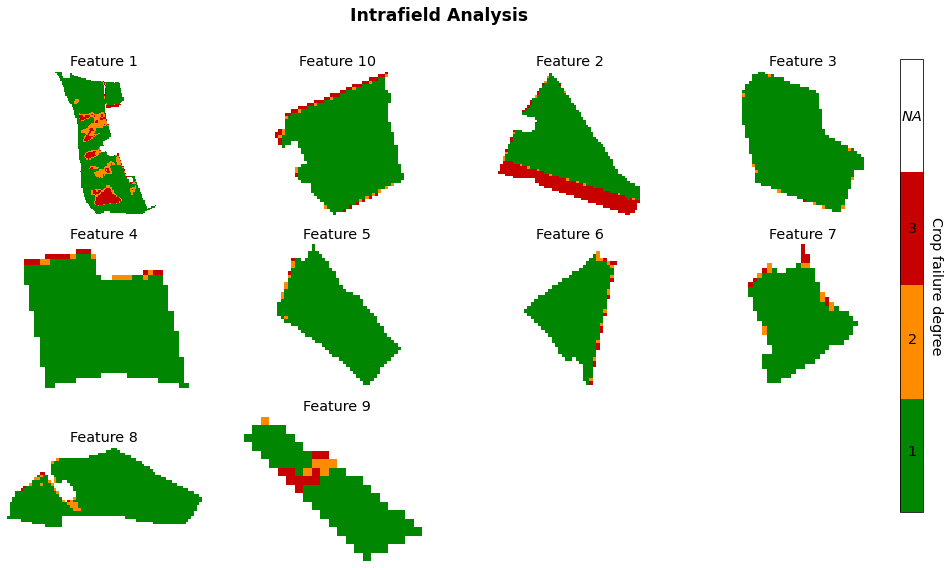

In [20]:
plot_intrafield_timeseries(all_intrafield[0])

In [21]:
get_intrafield_stats(all_intrafield[0])

datetime  count_value  mean_value feature_id  intrafield_green  \
0  2020-05-15T10:08:44Z         3863      0.5859          1           77.5045   
1  2020-05-10T10:08:37Z         1063      0.8376         10           93.9793   
2  2020-05-10T10:08:37Z         1546      0.6129          2           76.1966   
3  2020-05-10T10:08:37Z         1030      0.8661          3           98.9320   
4  2020-05-10T10:08:37Z          610      0.8344          4           96.0656   
5  2020-05-25T10:08:45Z          670      0.8975          5           98.5075   
6  2020-05-10T10:08:37Z          494      0.7541          6           94.5344   
7  2020-05-10T10:08:37Z          340      0.8354          7           93.5294   
8  2020-05-25T10:08:45Z         1231      0.8222          8           97.4817   
9  2020-06-29T10:08:41Z          119      0.7027          9           86.5546   

   intrafield_orange  intrafield_red  
0            12.6586          9.8369  
1             1.7874          4.2333  
2             1.0996         22.7038  
3             0.9709          0.0971  
4             1.6393          2.2951  
5             1.1940          0.2985  
6             2.8340          2.6316  
7             3.2353          3.2353  
8             2.1121          0.4062  
9             5.0420          8.4034

# Interfield Analysis

The scope of the service is to assess the status of the crop during the growing season and to provide an indicator about the crop behaviour with respect to the reference NDVI profile in the Area of Interest.

<p style="text-align: center"><img src="images/interfield.png" height="300px"/></p>

A brief description of the steps of the interfield analysis follows:

- Extraction of the reference NDVI temporal profile in the time range of interest. This reference is calculated as the average of parcels median values computed by zonal stats node `aggregate_spatials`;

- Calculation of distances between the reference and each parcel NDVI temporal profile;

- Identification of parcels with an anomalous behaviour by means of an unsupervised method. It assigns a class (`low`, `medium` or `high`) based on the worst case distance from the reference.

In [22]:
interfield_data_cube = aggregate_spatial_stats.process("interfield", data = sentinel2_data_cube, stats = aggregate_spatial_stats)

In [23]:
interfield_data_cube = interfield_data_cube.process("save_result", data = interfield_data_cube, format="JSON")

### Submit processing request to openEO backend

In [24]:
job = con.create_job(interfield_data_cube)
print(f"Job ID is: {job.job_id}")

Job ID is: ad2e4fcf-f957-46f3-9b2c-85cf6dde2546


In [25]:
job.start_and_wait()

0:00:00 Job 'ad2e4fcf-f957-46f3-9b2c-85cf6dde2546': send 'start'
0:00:00 Job 'ad2e4fcf-f957-46f3-9b2c-85cf6dde2546': queued (progress N/A)
0:00:05 Job 'ad2e4fcf-f957-46f3-9b2c-85cf6dde2546': running (progress N/A)
0:00:11 Job 'ad2e4fcf-f957-46f3-9b2c-85cf6dde2546': running (progress N/A)
0:00:19 Job 'ad2e4fcf-f957-46f3-9b2c-85cf6dde2546': running (progress N/A)
0:00:29 Job 'ad2e4fcf-f957-46f3-9b2c-85cf6dde2546': running (progress N/A)
0:00:41 Job 'ad2e4fcf-f957-46f3-9b2c-85cf6dde2546': running (progress N/A)
0:00:56 Job 'ad2e4fcf-f957-46f3-9b2c-85cf6dde2546': running (progress N/A)
0:01:15 Job 'ad2e4fcf-f957-46f3-9b2c-85cf6dde2546': running (progress N/A)
0:01:39 Job 'ad2e4fcf-f957-46f3-9b2c-85cf6dde2546': running (progress N/A)
0:02:09 Job 'ad2e4fcf-f957-46f3-9b2c-85cf6dde2546': finished (progress N/A)


<RESTJob job_id='ad2e4fcf-f957-46f3-9b2c-85cf6dde2546'>

In [26]:
results = job.get_results()
results

<JobResults for job 'ad2e4fcf-f957-46f3-9b2c-85cf6dde2546'>

In [27]:
output_directory = os.path.join(local_directory, job.job_id)
os.makedirs(output_directory, exist_ok=True)

all_interfield = results.download_files(output_directory)

In [28]:
output_geojsons = [output for output in all_interfield if os.path.basename(output).endswith(".json")]
get_interfield_stats(output_geojsons[0])

distance_difference  distance_from_reference  max_distance feature_id
0                 low                    0.234         4.652          1
1                 low                    0.400         4.652         10
2                 low                    0.246         4.652          2
3                 low                    0.362         4.652          3
4                 low                    0.417         4.652          4
5                 low                    0.411         4.652          5
6                 low                    0.247         4.652          6
7                 low                    0.440         4.652          7
8                 low                    0.420         4.652          8
9                high                    2.690         4.652          9